In [1]:
from astropy import units as u
from astropy.coordinates import SkyCoord
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.integrate import quad
import multiprocessing as mp
import gc
import matplotlib.colors as colors
from matplotlib import rcParams 
from scipy.stats import gaussian_kde
from scipy.stats import binned_statistic_2d
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
ms=pd.read_csv('../Downloads/catalog/final/starall_sm.csv')

In [3]:
mb=ms[ms.gr<0.6]
mr=ms[ms.gr>0.6]

In [4]:
plt.rcParams.update({'figure.figsize': (6, 6),
                   'font.size':25,
                   'text.usetex':True,
                   'mathtext.default' : 'it',
                   'axes.labelsize': 32,
                   'legend.fontsize': 25,
                   'legend.fancybox': False,
                   'legend.numpoints': 1,
                   'xtick.labelsize': 32,
                   'ytick.labelsize': 32,
                   'ytick.major.width':0.8,
                   'ytick.major.size':8,
                   'ytick.minor.size':4,
                   'xtick.major.width': 0.8,
                   'xtick.major.size':8,
                   'xtick.minor.size':4,
                   'axes.linewidth':2,
                   'lines.linewidth':2,
                   'xtick.direction':'in',
                   'ytick.direction':'in',
                   'savefig.bbox': 'tight', # 'tight' or 'standard'.
                   'savefig.pad_inches' : 0.1})
plt.rc('font',**{'family':'serif','serif':['Computer Modern'],'sans-serif':['Computer Modern']})

from matplotlib.ticker import FuncFormatter
#%matplotlib inline

import glob

In [28]:
plt.rcParams.update({'figure.figsize': (6, 6),
                   'font.size':26,
                   'text.usetex':True,
                   'mathtext.default' : 'it',
                   'axes.labelsize': 24,
                   'legend.fontsize': 22,
                   'legend.fancybox': False,
                   'legend.numpoints': 1,
                   'xtick.labelsize': 22,
                   'ytick.labelsize': 22,
                   'ytick.major.width':0.8,
                   'ytick.major.size':8,
                   'ytick.minor.size':4,
                   'xtick.major.width': 0.8,
                   'xtick.major.size':8,
                   'xtick.minor.size':4,
                   'axes.linewidth':2,
                   'lines.linewidth':2,
                   'xtick.direction':'in',
                   'ytick.direction':'in',
                   'savefig.bbox': 'tight', # 'tight' or 'standard'.
                   'savefig.pad_inches' : 0.1})
#plt.rc('font',**{'family':'serif','serif':['Computer Modern'],'sans-serif':['Computer Modern']})

from matplotlib.ticker import FuncFormatter
#%matplotlib inline

import glob

In [5]:
# given vectors x and y, fit medians in bins from xMin to xMax, with Nbin steps,
# and return xBin, medianBin, medianErrBin 
def fitMedians(x, y, xMin, xMax, Nbin, verbose=1): 

    # first generate bins
    xEdge = np.linspace(xMin, xMax, (Nbin+1)) 
    xBin = np.linspace(0, 1, Nbin)
    nPts = 0*np.linspace(0, 1, Nbin)
    medianBin = 0*np.linspace(0, 1, Nbin)
    sigGbin = -1+0*np.linspace(0, 1, Nbin) 
#    sigGbin2 = -1+0*np.linspace(0, 1, Nbin) #for measurement error
    for i in range(0, Nbin): 
        xBin[i] = 0.5*(xEdge[i]+xEdge[i+1]) 
        yAux1 = y[(x>xEdge[i])&(x<=xEdge[i+1])]
#        yErr = ye[(x>xEdge[i])&(x<=xEdge[i+1])]
        yAux = yAux1[(yAux1<np.percentile(yAux1,99.85))&(yAux1>np.percentile(yAux1,0.15))]#3sigma clipping
#        yErr = yErr[(yAux1<np.percentile(yAux1,99.85))&(yAux1>np.percentile(yAux1,0.15))]#3sigma clipping
        if (yAux.size > 0):
            nPts[i] = yAux.size
            medianBin[i] = np.median(yAux) #mean
            # robust estimate of standard deviation: 0.741*(q75-q25)
            sigmaG = 0.741*(np.percentile(yAux,75)-np.percentile(yAux,25))
            # uncertainty of the median: sqrt(pi/2)*st.dev/sqrt(N)
            sigGbin[i] = np.sqrt(np.pi/2)*sigmaG/np.sqrt(nPts[i])
#            sigGbin2[i] = np.median(yErr)/np.sqrt(nPts[i]) #measurement error 
        else:
            nPts[i] = 0 
            medianBin[i] = 0 
            sigGbin[i] = 0 
            sigGbin2[i] = 0 
            # nPts[i], medianBin[i], sigGBin[i] = 0 
        
    if (verbose):
        print('median:', np.median(medianBin[nPts>0]))

    return xBin, nPts, medianBin, sigGbin#, sigGbin2

1
2


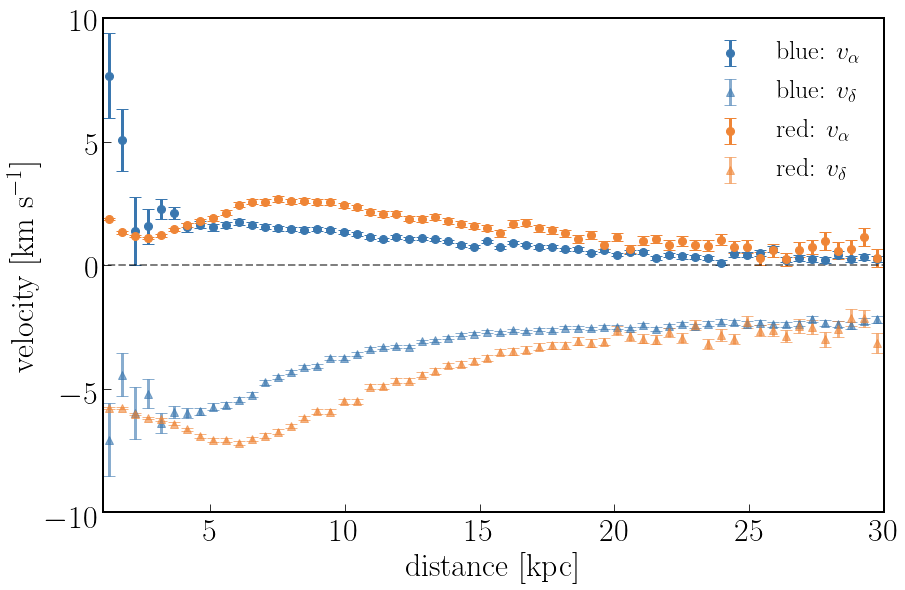

In [15]:
t=[ms,mb,mr]
c=['all','blue','red']
color1=['darkblue','blue','cyan']
color2=['darkred','red','pink']
calpha='#3A77AF'
cdec='#EF8536'
cblue='#3A77AF'
cred='#EF8536'
fig=plt.figure(figsize=(14,20))
#fig=plt.figure(figsize=(16,20))
ax = plt.subplot(212)
#ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
#ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
ax.set_xlim(1,30)
ax.set_ylim(-10,10)
ax.set_xlabel('distance [kpc]',fontsize=32)
ax.set_ylabel('velocity [km s$^{-1}]$',fontsize=32)
# binned medians to be more quantitative 
#for i in range(3):
for i in range(3):
    if i ==0:
        continue
    print(i)
    r = t[i].r_psfflux_mag
    gr = t[i].gr
    D = t[i].Dkpc
    vra = t[i].pmra_cl
    vdec = t[i].pmdec_cl
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vra, 1, 30, 60, 0)
    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 1, 30, 60, 0)
#    ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='-',color=color1[i] ,capsize=2, alpha=0.9, label=c[i]+r' stars $v_\alpha$ median')
#    ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='-',color=color2[i], capsize=2, alpha=0.9, label=c[i]+r' stars $v_\delta$ median')
    if i==1:
        ax.errorbar(x1Bin, m1edianBin, s1igGbin,fmt='o',color=cblue,capsize=6, markersize=8,alpha=1, label=c[i]+r': $v_\alpha$',lw=3)
        ax.errorbar(x2Bin, m2edianBin, s2igGbin,fmt='^',color=cblue,capsize=6, markersize=8,alpha=0.6, label=c[i]+r': $v_\delta$',lw=3)
        continue
    if i == 2:
        ax.errorbar(x1Bin, m1edianBin, s1igGbin,fmt='o',c=cred,capsize=6, markersize=8,alpha=1., label=c[i]+r': $v_\alpha$',lw=3)
        ax.errorbar(x2Bin, m2edianBin, s2igGbin,fmt='^',c=cred,capsize=6,markersize=8, alpha=0.6, label=c[i]+r': $v_\delta$',lw=3)
        continue
xL = np.linspace(0,100)
ax.plot(xL, 0*xL+0.00, c='black',linestyle='--',alpha=0.5)
#ax.savefig('test.pdf')
#plt.title('proper motion vs. distance for stars')
plt.legend(frameon=False,fontsize=26)
plt.savefig('../Documents/final/check/test_plot2.pdf')